In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 1. 전국 시도별 공연 시설 정보 원그래프

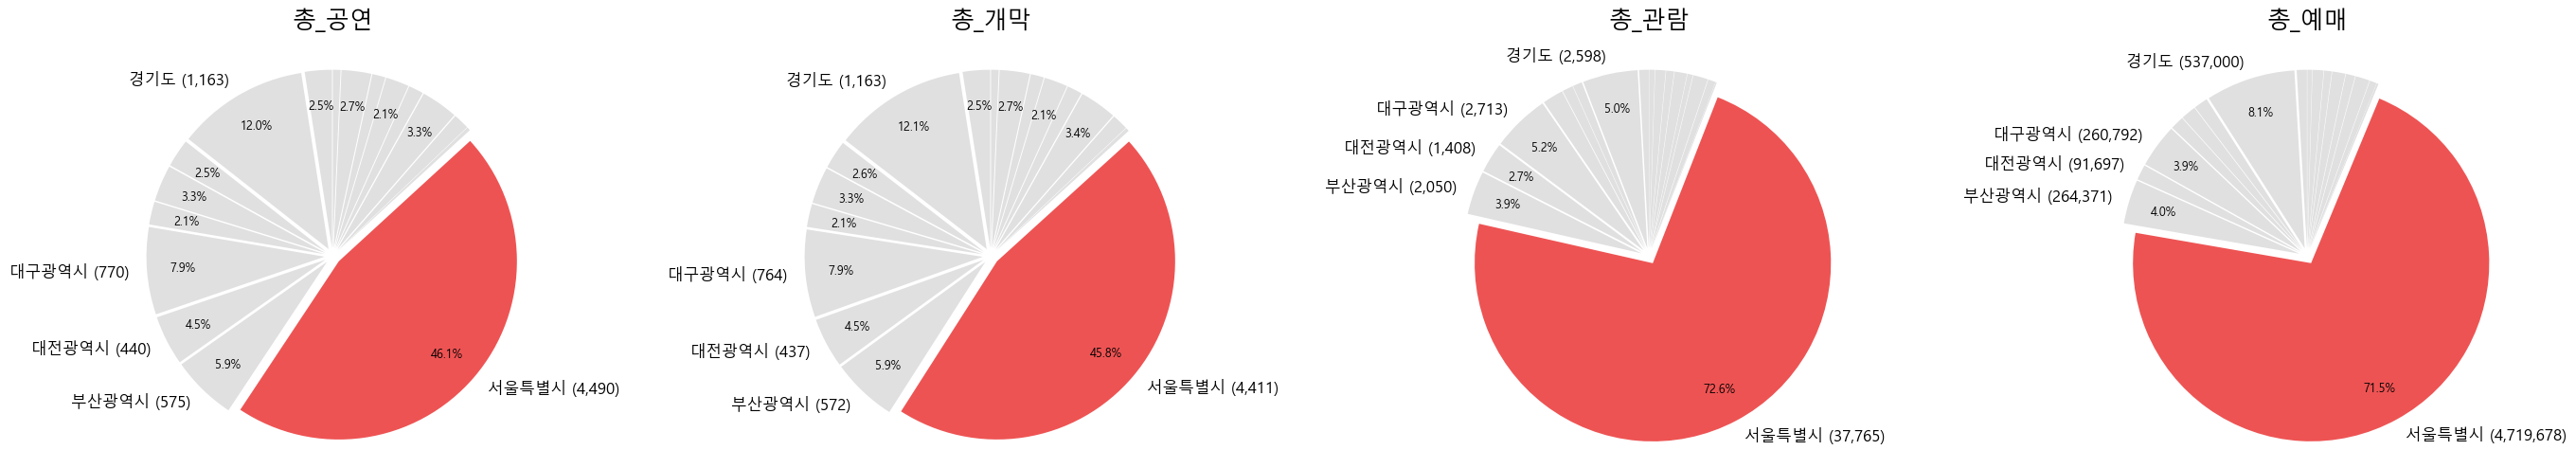

In [ ]:
# --- 1. 초기 설정 및 데이터 로딩 ---
# Matplotlib 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 데이터 로딩
data_path = '../data/01_Problem_Definition/'
performance_file = f'{data_path}KC_486_WNTY_KOPIS_PRFPLC_2022.csv'
columns_file = f'{data_path}전국 KOPIS 공연시설 데이터(시군_컬럼정의서.xls'
performance_df = pd.read_csv(performance_file, encoding='utf-8')
column_names_kr = pd.read_excel(columns_file)['컬럼한글명'].tolist()

# --- 2. 데이터 전처리 ---
# 컬럼명 변경
performance_df.columns = column_names_kr

# 필요한 컬럼만 선택 (순서 변경 및 좌석 수 컬럼 처리 포함)
required_columns = ["시설명", "시도명", "시군구명", "시설경도", "시설위도", "시설좌석수", 
                    "공연장수", '공연건수', '개막건수', '관람건수', '예매건수', '민간공공여부', 
                    '도로명주소명', '전화번호', '홈페이지주소']
performance_df = performance_df[required_columns]

# 중복된 컬럼명 처리
performance_df = performance_df.loc[:, ~performance_df.columns.duplicated(keep='first')]

# 좌석 수가 0인 데이터 필터링
performance_df = performance_df.query("시설좌석수 != 0").copy()

# --- 3. 데이터 집계 ---
# 시도명 기준으로 주요 지표 집계
summary_by_region = performance_df.groupby('시도명').agg(
    총_공연=('공연건수', 'sum'),
    총_개막=('개막건수', 'sum'),
    총_관람=('관람건수', 'sum'),
    총_예매=('예매건수', 'sum')
)

# --- 4. 데이터 시각화 함수 정의 ---
def create_highlighted_pie_chart(ax, data_series, title):
    """상위 5개 항목을 강조하는 파이 차트를 그리는 함수"""
    
    # 1. 데이터 및 비율 계산
    total = data_series.sum()
    proportions = (data_series / total) * 100
    
    num_slices = len(proportions)
    explode = [0.05] * num_slices
    
    # 가장 큰 값을 가진 항목(서울)을 강조하기 위한 색상 리스트 생성
    colors = ['#E0E0E0'] * num_slices  # 기본 색상
    top_index = proportions.idxmax() # 가장 큰 값의 인덱스
    top_color = '#EE5353'            # 강조 색상
    colors[proportions.index.get_loc(top_index)] = top_color

    # 2. 퍼센트 표시 함수
    def label_func(pct):
        return f'{pct:.1f}%' if pct > 2 else ''

    # 3. 파이 차트 그리기
    wedges, texts, autotexts = ax.pie(
        proportions, 
        labels=proportions.index,
        autopct=label_func, 
        colors=colors, 
        explode=explode, 
        startangle=90,
        radius=1.1,
        pctdistance=0.8
    )
    
    ax.set_title(title, fontsize=18, pad=20)
    
    top5_indices = proportions.nlargest(5).index
    for i, label in enumerate(proportions.index):
        if label in top5_indices:
            value = data_series[label]
            texts[i].set_text(f'{label} ({value:,})')
        else:
            texts[i].set_text('')
        
    for text in texts:
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_fontsize(9)
    
# --- 5. 그래프 그리기 ---
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 8))

for ax, column in zip(axes.flatten(), summary_by_region.columns):
    create_highlighted_pie_chart(ax, summary_by_region[column], column)

plt.tight_layout(pad=4.0)
plt.show()


# 2. 전국 공연장 운영 현황

c:\대학생활\공모전\KOPIS\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\대학생활\공모전\KOPIS\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


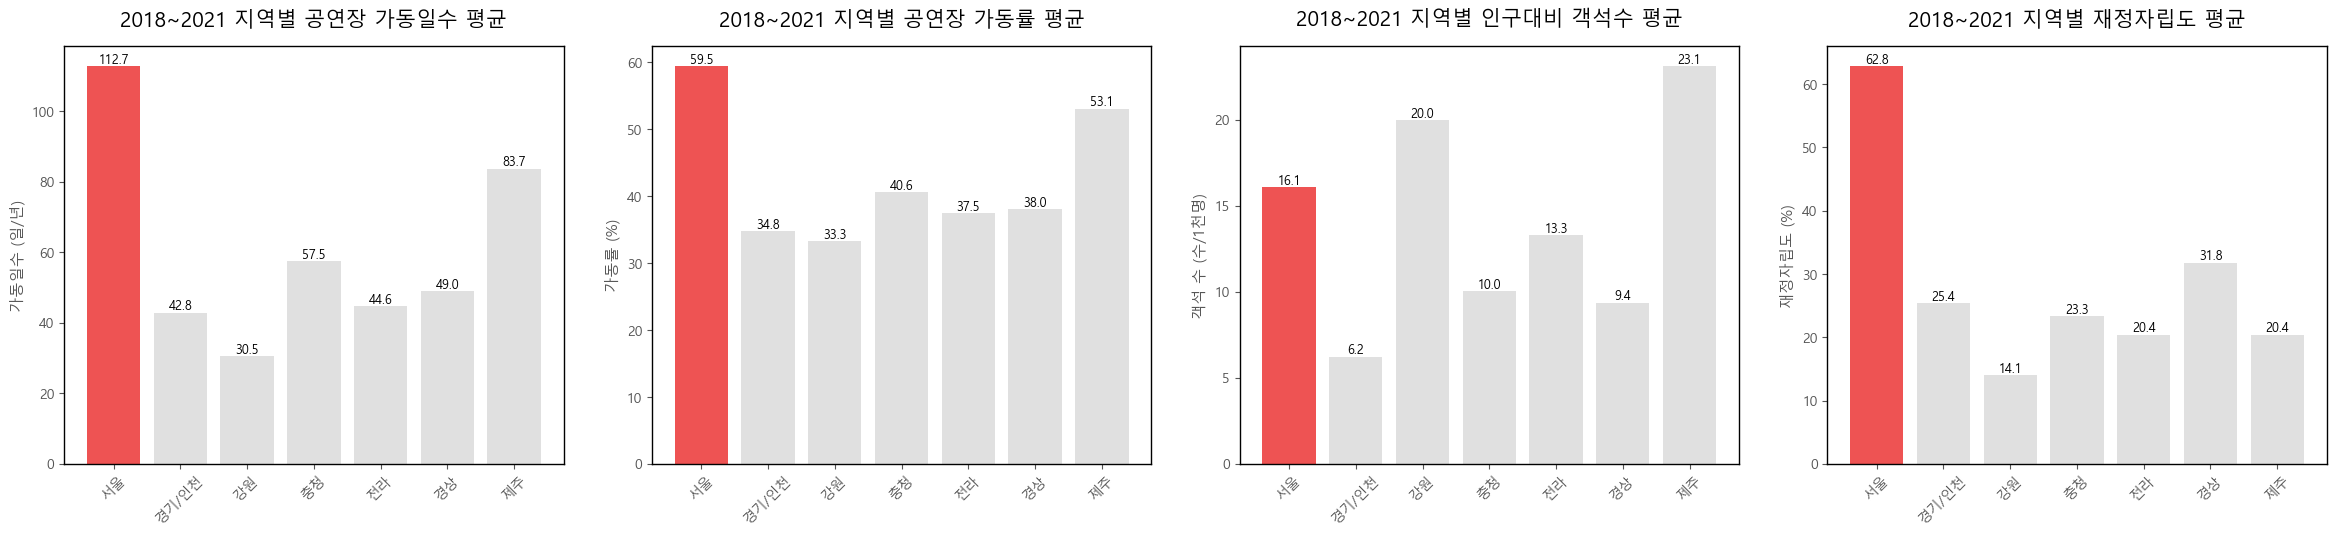

In [ ]:
# --- 1. 초기 설정 ---
# Matplotlib 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.style.use('ggplot') # 일관된 스타일 적용

# --- 2. 데이터 처리 및 시각화 함수 정의 ---

def process_and_plot_bar(ax, filepath, rows, title, ylabel):
    """
    엑셀 파일을 읽고, 데이터를 처리한 후, 지정된 스타일로 막대그래프를 그리는 함수
    
    Args:
        ax (matplotlib.axes.Axes): 그래프를 그릴 Matplotlib의 Axes 객체
        filepath (str): 엑셀 파일 경로
        rows (list): 추출할 행 인덱스 리스트
        title (str): 그래프 제목
        ylabel (str): Y축 라벨
    """
    # 2-1. 데이터 로딩 및 전처리
    columns_to_process = ['2018', '2019', '2020', '2021']
    df = pd.read_excel(filepath)
    
    # 지정된 행과 열을 선택하여 4년치 평균 계산
    processed_series = df.loc[rows, columns_to_process].mean(axis=1)
    processed_series.index = ['서울', '경기/인천', '강원', '충청', '전라', '경상', '제주']

    # 2-2. 시각화
    # 서울만 강조하는 동적 색상 리스트 생성
    colors = ['#EE5353'] + ['#E0E0E0'] * (len(processed_series) - 1)
    
    # 막대그래프 그리기
    bars = ax.bar(processed_series.index, processed_series.values, color=colors)
    
    # 그래프 스타일 설정
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(False)

    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}', 
                ha='center', va='bottom', fontsize=9)

# --- 3. 그래프 그리기 ---

# 그래프별 설정 값 정의
data_path = '../data/01_Problem_Definition/'
chart_configs = [
    {
        "filepath": f'{data_path}공연시설__공연장_가동일수_20230701144547.xlsx',
        "rows": [128, 135, 142, 149, 156, 163, 170],
        "title": '2018~2021 지역별 공연장 가동일수 평균',
        "ylabel": '가동일수 (일/년)'
    },
    {
        "filepath": f'{data_path}공연시설__공연장_가동률_20230701155600.xlsx',
        "rows": [19, 20, 21, 22, 23, 24, 25],
        "title": '2018~2021 지역별 공연장 가동률 평균',
        "ylabel": '가동률 (%)'
    },
    {
        "filepath": f'{data_path}공연시설__인구_1천명당_객석수_현황_20230701123748.xlsx',
        "rows": [94, 99, 104, 109, 114, 119, 124],
        "title": '2018~2021 지역별 인구대비 객석수 평균',
        "ylabel": '객석 수 (수/1천명)'
    },
    {
        "filepath": f'{data_path}공연시설__재정자립도_20230701155500.xlsx',
        "rows": [19, 20, 21, 22, 23, 24, 25],
        "title": '2018~2021 지역별 재정자립도 평균',
        "ylabel": '재정자립도 (%)'
    }
]

# Figure와 Axes 생성
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

# 설정 값을 순회하며 그래프 그리기
for ax, config in zip(axes.flatten(), chart_configs):
    process_and_plot_bar(
        ax=ax,
        filepath=config["filepath"],
        rows=config["rows"],
        title=config["title"],
        ylabel=config["ylabel"]
    )

plt.tight_layout(pad=3.0)
plt.show()

# 3. 전국 공공/민간 공연장 비율, 전국 지역별 등록예술인 수

C:\Users\sksms\AppData\Local\Temp\ipykernel_2324\2795096674.py:91: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  public_counts = grouped_by_area.apply(lambda g: g[g['시설특성'].str.contains('공공|국립')]['시설특성'].count())
C:\Users\sksms\AppData\Local\Temp\ipykernel_2324\2795096674.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  private_counts = grouped_by_area.apply(lambda g: g[g['시설특성'].str.contains('민간')]['시설특성'].count

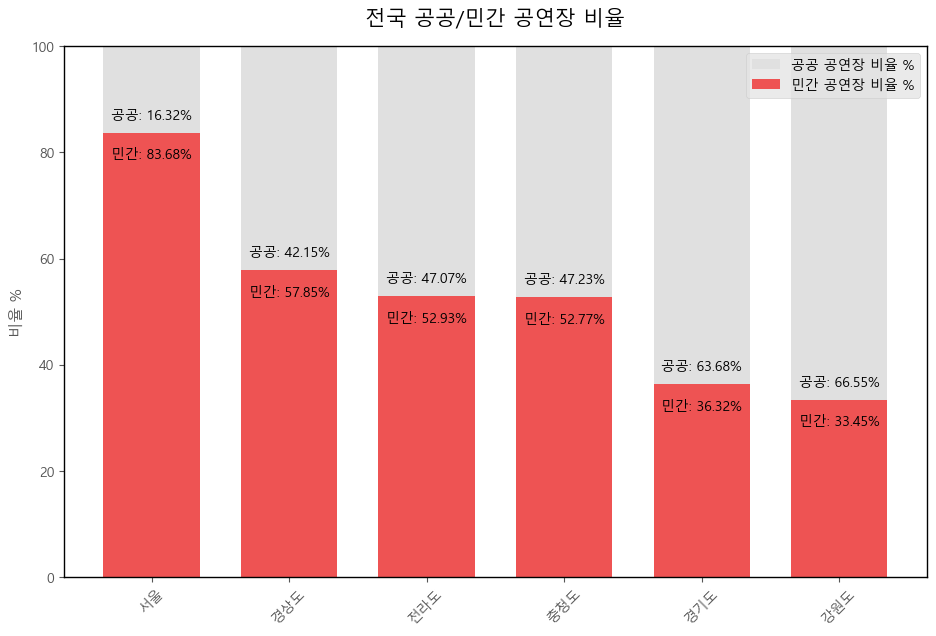

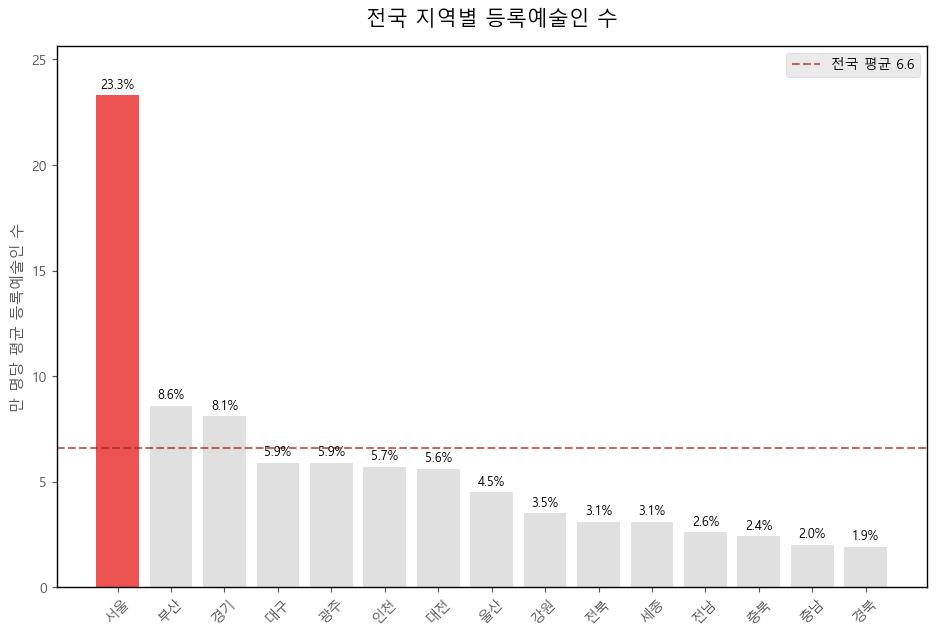

In [ ]:
# --- 1. 초기 설정 ---
# Matplotlib 폰트 및 스타일 설정
plt.rc('font', family='Malgun Gothic')

# --- 2. 데이터 처리 및 시각화 함수 정의 ---

def plot_stacked_ratio_bar(ax, data, title):
    """
    공공/민간 공연장 비율을 나타내는 누적 막대그래프를 그리는 함수
    """
    # 데이터 정렬
    data = data.sort_values(by='민간_비율', ascending=False)
    
    areas = data.index
    bar_positions = range(len(areas))
    bar_width = 0.7

    # 누적 막대그래프 그리기
    # 100% 배경 막대 (공공 비율)
    ax.bar(bar_positions, [100] * len(areas), width=bar_width, color='#E0E0E0', label='공공 공연장 비율 %')
    # 민간 비율 막대
    ax.bar(bar_positions, data['민간_비율'], width=bar_width, color='#EE5353', label='민간 공연장 비율 %')

    # 각 막대에 비율 값 표시
    for i, row in data.iterrows():
        private_ratio = row['민간_비율']
        public_ratio = 100 - private_ratio
        # 민간 비율 텍스트
        ax.text(bar_positions[data.index.get_loc(i)], private_ratio - 3, f'민간: {private_ratio:.2f}%', 
                ha='center', va='top', fontsize=10, color='black')
        # 공공 비율 텍스트
        ax.text(bar_positions[data.index.get_loc(i)], private_ratio + 2, f'공공: {public_ratio:.2f}%', 
                ha='center', va='bottom', fontsize=10, color='black')

    # 그래프 스타일 설정
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_ylabel('비율 %', fontsize=11)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(areas, rotation=45)
    ax.set_ylim(0, 100)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.legend()

def plot_highlighted_bar(ax, data, x_col, y_col, highlight_val, avg_line, title, ylabel):
    """
    특정 항목을 강조하고 평균선을 포함하는 막대그래프를 그리는 함수
    """
    # 동적 색상 리스트 생성
    colors = ['#EE5353' if val == highlight_val else '#E0E0E0' for val in data[x_col]]
    
    # 막대그래프 그리기
    bars = ax.bar(data[x_col], data[y_col], color=colors)
    
    # 전국 평균 선 그리기
    ax.axhline(y=avg_line, color='brown', linestyle='--', label=f'전국 평균 {avg_line}', alpha=0.7)
    
    # 그래프 스타일 설정
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, max(data[y_col]) * 1.1) # Y축 범위 자동 조절
    ax.grid(False)
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.legend()

    # 각 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.2, f'{height}%', 
                ha='center', va='bottom', fontsize=9)

# --- 3. 데이터 처리 실행 ---

# 3-1. 공공/민간 공연장 데이터 처리
data_path = '../data/01_Problem_Definition/'
files = [f'{data_path}kopis_{year}.xlsx' for year in [22, 21, 20, 19]]
df_list = [pd.read_excel(file) for file in files]
combined_df = pd.concat(df_list, ignore_index=True)

grouped_by_area = combined_df.groupby('공연지역명')

public_counts = grouped_by_area.apply(lambda g: g[g['시설특성'].str.contains('공공|국립')]['시설특성'].count())
private_counts = grouped_by_area.apply(lambda g: g[g['시설특성'].str.contains('민간')]['시설특성'].count())

ratio_df = pd.DataFrame({'공공': public_counts, '민간': private_counts})
ratio_df['민간_비율'] = (ratio_df['민간'] / (ratio_df['공공'] + ratio_df['민간'])) * 100
ratio_df = ratio_df.loc[['서울', '경상도', '충청도', '전라도', '경기도', '강원도']] 

# 3-2. 등록 예술인 데이터 처리
artist_data = {
    '지역': ['서울', '부산', '경기', '대구', '광주', '인천', '대전', '울산', '강원', '전북', '세종', '전남', '충북', '충남', '경북'],
    '비율': [23.3, 8.6, 8.1, 5.9, 5.9, 5.7, 5.6, 4.5, 3.5, 3.1, 3.1, 2.6, 2.4, 2.0, 1.9]
}
artist_df = pd.DataFrame(artist_data)

# --- 4. 그래프 그리기 ---
# 첫 번째 그래프: 공공/민간 비율
fig1, ax1 = plt.subplots(figsize=(10, 7))
fig1.patch.set_facecolor('white')
plot_stacked_ratio_bar(ax1, ratio_df, '전국 공공/민간 공연장 비율')
plt.tight_layout(pad=3.0)
plt.show()

# 두 번째 그래프: 등록 예술인 수
fig2, ax2 = plt.subplots(figsize=(10, 7))
fig2.patch.set_facecolor('white')
plot_highlighted_bar(ax2, artist_df, x_col='지역', y_col='비율', 
                     highlight_val='서울', avg_line=6.6,
                     title='전국 지역별 등록예술인 수',
                     ylabel='만 명당 평균 등록예술인 수')
plt.tight_layout(pad=3.0)
plt.show()